In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

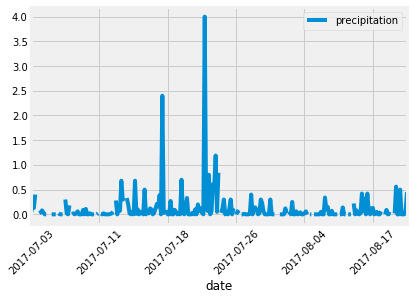

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2018, 7, 3) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
# df = df.sort_values("date")
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,249.000000
mean,0.112129
std,0.332741
min,0.000000
25%,0.000000
50%,0.010000
75%,0.100000
max,4.000000


In [30]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [31]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

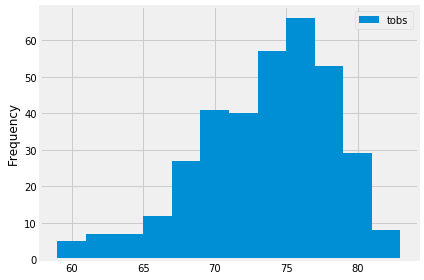

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [38]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-07-03', '2018-08-17'))


[(69.0, 78.60144927536231, 87.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2017, 7, 7) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 8, 17) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

58.0 74.93447862564922 87.0


C:\Users\ca25935\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


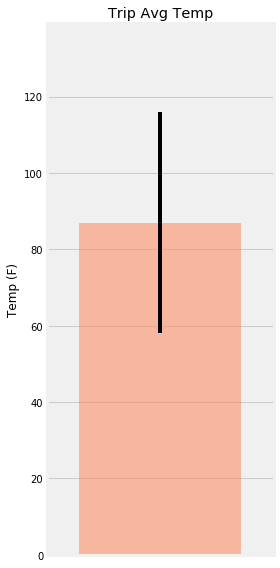

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-07-07'
end_date = '2018-08-17'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 17.300000000000008), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.82), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.7999999999999994), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.8900000000000006), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.83), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.36000000000000004), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]
